### Imports

In [70]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
import math 
import os 

### Visualization Functions

In [71]:
# Function to save and plot SIRV proportions
def saveAndPlotSIRVProportions(S, I_var, R, X, population, I, T, output_folder):
    # Load county names from the inputData folder
    county_names_path = os.path.join("inputData", "floridaCountyNames.csv")
    county_names_df = pd.read_csv(county_names_path)
    county_names = county_names_df["County"].tolist()

    # Collect SIRV proportions data
    sirvData = []
    for i in I:
        for t in T:
            total_population = population[i]
            s_prop = S[i, t].x / total_population if total_population > 0 else 0
            i_prop = I_var[i, t].x / total_population if total_population > 0 else 0
            r_prop = R[i, t].x / total_population if total_population > 0 else 0
            x_prop = X[i, t].x / total_population if total_population > 0 else 0
            sirvData.append([i, t, s_prop, i_prop, r_prop, x_prop])
    
    sirvDf = pd.DataFrame(sirvData, columns=["region", "timePeriod", "S_proportion", "I_proportion", "R_proportion", "X_proportion"])
    sirv_csv_path = os.path.join(output_folder, "sirvProportions.csv")
    sirvDf.to_csv(sirv_csv_path, index=False)
    print(f"SIRV proportions data saved to '{sirv_csv_path}'")

    numRegions = len(I)
    rows = 23
    cols = math.ceil(numRegions / rows)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 60), sharex=True, sharey=True)
    fig.suptitle("SIRV Proportions Over Time for Each County", fontsize=16, y=0.95) 
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to reduce gap

    for idx, i in enumerate(I):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        regionData = sirvDf[sirvDf["region"] == i]
        county_name = county_names[i - 1]  # Access county name using region index
        ax.plot(regionData["timePeriod"], regionData["S_proportion"], label="S", color="blue")
        ax.plot(regionData["timePeriod"], regionData["I_proportion"], label="I", color="red")
        ax.plot(regionData["timePeriod"], regionData["R_proportion"], label="R", color="green")
        ax.plot(regionData["timePeriod"], regionData["X_proportion"], label="V", color="orange")
        ax.set_title(county_name, fontsize=10)  # Set title using county name
        ax.grid(True)
        
        # Add legend to each subplot
        ax.legend(loc="upper right", fontsize=6)

        if row == rows - 1:
            ax.set_xlabel("Time Period")
        if col == 0:
            ax.set_ylabel("Proportion")

    plot_path = os.path.join(output_folder, "sirvProportions.png")
    plt.savefig(plot_path, bbox_inches='tight')
    print(f"SIRV proportions plot saved to '{plot_path}'")
    plt.show()


# Function to save all decision variables to CSV files
def saveDecisionVariables(Z, A, S, I_var, R, X, H, U, v, output_folder, T, T_prime, I, J):
    # Save travel data
    travelData = []
    for i in I:
        for j in J:
            for tPrime in T_prime:
                quantity = Z[i, j, tPrime].x
                if quantity > 0:
                    travelData.append([i, j, tPrime, quantity])
    travel_csv_path = os.path.join(output_folder, "travelData.csv")
    travelDf = pd.DataFrame(travelData, columns=["fromRegion", "toFacility", "timePeriod", "quantity"])
    travelDf.to_csv(travel_csv_path, index=False)
    print(f"Travel data saved to '{travel_csv_path}'")

    # Save vaccine allocation data
    vaccineAllocationData = []
    for i in I:
        for tPrime in T_prime:
            quantity = A[i, tPrime].x
            if quantity > 0:
                vaccineAllocationData.append([i, tPrime, quantity])
    vaccine_csv_path = os.path.join(output_folder, "vaccineAllocationData.csv")
    vaccineAllocationDf = pd.DataFrame(vaccineAllocationData, columns=["region", "timePeriod", "allocatedVaccines"])
    vaccineAllocationDf.to_csv(vaccine_csv_path, index=False)
    print(f"Vaccine allocation data saved to '{vaccine_csv_path}'")

    # Save susceptible population
    susceptibleData = []
    for i in I:
        for t in T:
            susceptibleData.append([i, t, S[i, t].x])
    susceptible_csv_path = os.path.join(output_folder, "susceptibleData.csv")
    susceptibleDf = pd.DataFrame(susceptibleData, columns=["region", "timePeriod", "susceptible"])
    susceptibleDf.to_csv(susceptible_csv_path, index=False)
    print(f"Susceptible data saved to '{susceptible_csv_path}'")

    # Save infected population
    infectedData = []
    for i in I:
        for t in T:
            infectedData.append([i, t, I_var[i, t].x])
    infected_csv_path = os.path.join(output_folder, "infectedData.csv")
    infectedDf = pd.DataFrame(infectedData, columns=["region", "timePeriod", "infected"])
    infectedDf.to_csv(infected_csv_path, index=False)
    print(f"Infected data saved to '{infected_csv_path}'")

    # Save recovered population
    recoveredData = []
    for i in I:
        for t in T:
            recoveredData.append([i, t, R[i, t].x])
    recovered_csv_path = os.path.join(output_folder, "recoveredData.csv")
    recoveredDf = pd.DataFrame(recoveredData, columns=["region", "timePeriod", "recovered"])
    recoveredDf.to_csv(recovered_csv_path, index=False)
    print(f"Recovered data saved to '{recovered_csv_path}'")

    # Save vaccinated population
    vaccinatedData = []
    for i in I:
        for t in T:
            vaccinatedData.append([i, t, X[i, t].x])
    vaccinated_csv_path = os.path.join(output_folder, "vaccinatedData.csv")
    vaccinatedDf = pd.DataFrame(vaccinatedData, columns=["region", "timePeriod", "vaccinated"])
    vaccinatedDf.to_csv(vaccinated_csv_path, index=False)
    print(f"Vaccinated data saved to '{vaccinated_csv_path}'")

    # Save hospitalizations
    hospitalizationData = []
    for i in I:
        for t in T:
            hospitalizationData.append([i, t, H[i, t].x])
    hospitalization_csv_path = os.path.join(output_folder, "hospitalizationData.csv")
    hospitalizationDf = pd.DataFrame(hospitalizationData, columns=["region", "timePeriod", "hospitalized"])
    hospitalizationDf.to_csv(hospitalization_csv_path, index=False)
    print(f"Hospitalization data saved to '{hospitalization_csv_path}'")

    # Save unmet demand
    unmetDemandData = []
    for i in I:
        for tPrime in T_prime:
            unmetDemandData.append([i, tPrime, U[i, tPrime].x])
    unmet_demand_csv_path = os.path.join(output_folder, "unmetDemandData.csv")
    unmetDemandDf = pd.DataFrame(unmetDemandData, columns=["region", "timePeriod", "unmetDemand"])
    unmetDemandDf.to_csv(unmet_demand_csv_path, index=False)
    print(f"Unmet demand data saved to '{unmet_demand_csv_path}'")

    # Save vaccinations administered
    vaccinationAdministeredData = []
    for i in I:
        for t in T:
            vaccinationAdministeredData.append([i, t, v[i, t].x])
    vaccinations_csv_path = os.path.join(output_folder, "vaccinationsAdministeredData.csv")
    vaccinationsDf = pd.DataFrame(vaccinationAdministeredData, columns=["region", "timePeriod", "vaccinationsAdministered"])
    vaccinationsDf.to_csv(vaccinations_csv_path, index=False)
    print(f"Vaccinations administered data saved to '{vaccinations_csv_path}'")

# Ensure the output folder exists
output_folder = "outputData"
os.makedirs(output_folder, exist_ok=True)

### Run the Model I NEED TO CHANGE HOW THE I IN SIR BEING ACCOUNTED FOR

In [72]:
# Load data files
distanceDF = pd.read_csv("inputData/Distance.csv", header=None)   # Distance between counties
capacityDF = pd.read_csv("inputData/Capacity.csv", header=None)   # Healthcare facility capacities
populationDF = pd.read_csv("inputData/Population.csv", header=None)  # Population per county
vaccineDF = pd.read_csv("inputData/Florida_Weekly_Vaccine_Summary.csv")  # Weekly vaccination data

# Define model parameters
t_B = 0                # Start time period
t_E = 26               # End time period (26 weeks)
psi = 1                # Decision interval
numCounties = 67       # Number of counties in Florida

# Define sets for counties, healthcare facilities, time periods, and decision periods
I = range(1, numCounties + 1)  # Set of regions (counties)
J = range(1, numCounties + 1)  # Set of healthcare facilities
T = range(t_B, t_E + 1)        # Set of time periods
T_prime = range(t_B, t_E + 1, psi)  # Set of decision-making time periods

# Initial values for SIRV model (absolute counts)
initial_S_fraction = 0.94
initial_I_fraction = 0.01
initial_R_fraction = 0.00
initial_X_fraction = 0.05

# Population for each county
population = {i: populationDF.iloc[i-1, 0] for i in I}
N = population

# Initialize counts for the SIRV model
initial_S = {i: initial_S_fraction * N[i] for i in I}  # Initial susceptible count
initial_I = {i: initial_I_fraction * N[i] for i in I}  # Initial infected count
initial_R = {i: initial_R_fraction * N[i] for i in I}  # Initial recovered count
initial_X = {i: initial_X_fraction * N[i] for i in I}  # Initial vaccinated count

# Model parameters
beta = {i: 0.5 for i in I}            # Transmission rate for each county
gamma = {i: 0.98 for i in I}           # Recovery rate for each county (e.g., 10-day infectious period)
l = {i: 0.1 for i in I}                # Leaky vaccine probability for each county (90% efficacy)
rho = {i: 0.05 for i in I}            # Hospitalization rate for each county (5% of infected individuals)
C = {j: capacityDF.iloc[j-1, 0] for j in J}  # Capacity at each healthcare facility
V_total = {t: 1000 for t in T_prime}   # Total vaccines available at each decision period
d = {(i, j): distanceDF.iloc[i-1, j-1] for i in I for j in J}  # Distance between counties
D_max = 100                            # Max travel distance allowed for healthcare
M = 1e6                                # Large number for big-M constraints in linear programming

# Ensure the output folder exists
output_folder = "outputData"
os.makedirs(output_folder, exist_ok=True)

# Initialize Gurobi model
model = gp.Model("SIRV_Model")

# Define decision variables (as absolute counts for SIRV)
S = model.addVars(I, T, lb=0, ub=N, name="S")          # Susceptible count per county and time
I_var = model.addVars(I, T, lb=0, ub=N, name="I")      # Infected count per county and time
R = model.addVars(I, T, lb=0, ub=N, name="R")          # Recovered count per county and time
X = model.addVars(I, T, lb=0, ub=N, name="X")          # Vaccinated count per county and time
v = model.addVars(I, T, lb=0, name="v")                # Vaccinations administered per county and time
H = model.addVars(I, T, lb=0, name="H")                # Hospitalized population per county and time
A = model.addVars(I, T_prime, lb=0, name="A")          # Vaccines allocated per county and decision period
Z = model.addVars(I, J, T_prime, lb=0, name="Z")       # Number of people transferred for healthcare
U = model.addVars(I, T_prime, lb=0, name="U")          # Unmet healthcare demand per county and time
b = model.addVars(I, J, T_prime, vtype=GRB.BINARY, name="b")  # Binary travel variable
W_SI = model.addVars(I, T, lb=0, name="W_SI")          # Auxiliary variable for linearizing S*I
Y_XI = model.addVars(I, T, lb=0, name="Y_XI")          # Auxiliary variable for linearizing X*I

# Objective: Minimize total unmet healthcare demand
model.setObjective(gp.quicksum(U[i, t_prime] for i in I for t_prime in T_prime), GRB.MINIMIZE)

# Constraints
for i in I:
    for t in T:
        if t == t_B:
            model.addConstr(S[i, t] == initial_S[i])
            model.addConstr(I_var[i, t] == initial_I[i])
            model.addConstr(R[i, t] == initial_R[i])
            model.addConstr(X[i, t] == initial_X[i])
        else:
            model.addConstr(S[i, t] == S[i, t-1] - beta[i] * W_SI[i, t-1] - v[i, t-1])
            model.addConstr(I_var[i, t] == I_var[i, t-1] + beta[i] * (W_SI[i, t-1] + l[i] * Y_XI[i, t-1]) - gamma[i] * I_var[i, t-1])
            model.addConstr(R[i, t] == R[i, t-1] + gamma[i] * I_var[i, t-1])
            model.addConstr(X[i, t] == X[i, t-1] + v[i, t-1] - l[i] * beta[i] * Y_XI[i, t-1])

        # Hospitalizations directly scaled by population
        model.addConstr(H[i, t] == rho[i] * I_var[i, t] * N[i])

for i in I:
    for t_prime in T_prime:
        model.addConstr(U[i, t_prime] == H[i, t_prime] - gp.quicksum(Z[i, j, t_prime] for j in J))

for j in J:
    for t_prime in T_prime:
        model.addConstr(gp.quicksum(Z[i, j, t_prime] for i in I) <= C[j])

for t_prime in T_prime:
    model.addConstr(gp.quicksum(A[i, t_prime] for i in I) <= V_total[t_prime])

for i in I:
    for t_prime in T_prime:
        model.addConstr(v[i, t_prime] <= A[i, t_prime])

for i in I:
    for t in T:
        model.addConstr(v[i, t] <= S[i, t])

for i in I:
    for j in J:
        for t_prime in T_prime:
            model.addConstr(Z[i, j, t_prime] <= M * b[i, j, t_prime])
            model.addConstr(d[i, j] * b[i, j, t_prime] <= D_max)
            model.addConstr(Z[i, j, t_prime] >= 0)

# Linearization constraints for W_SI and Y_XI (McCormick envelopes)
for i in I:
    for t in T:
        model.addConstr(W_SI[i, t] >= 0)
        model.addConstr(W_SI[i, t] >= N[i] * I_var[i, t] + N[i] * S[i, t] - N[i] ** 2)
        model.addConstr(W_SI[i, t] <= N[i] * S[i, t])
        model.addConstr(W_SI[i, t] <= N[i] * I_var[i, t])
        model.addConstr(Y_XI[i, t] >= 0)
        model.addConstr(Y_XI[i, t] >= N[i] * I_var[i, t] + N[i] * X[i, t] - N[i] ** 2)
        model.addConstr(Y_XI[i, t] <= N[i] * X[i, t])
        model.addConstr(Y_XI[i, t] <= N[i] * I_var[i, t])

# Optimize the model
model.optimize()


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 394389 rows, 260496 columns and 794602 nonzeros
Model fingerprint: 0xd7543abf
Variable types: 139293 continuous, 121203 integer (121203 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 4e+06]
Presolve removed 374621 rows and 234118 columns
Presolve time: 0.11s
Presolved: 19768 rows, 26378 columns, 78044 nonzeros
Variable types: 26378 continuous, 0 integer (0 binary)

Root relaxation: objective -6.798932e-10, 2956 iterations, 0.07 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0    

### Plot and Save Results

SIRV proportions data saved to 'outputData\sirvProportions.csv'
SIRV proportions plot saved to 'outputData\sirvProportions.png'


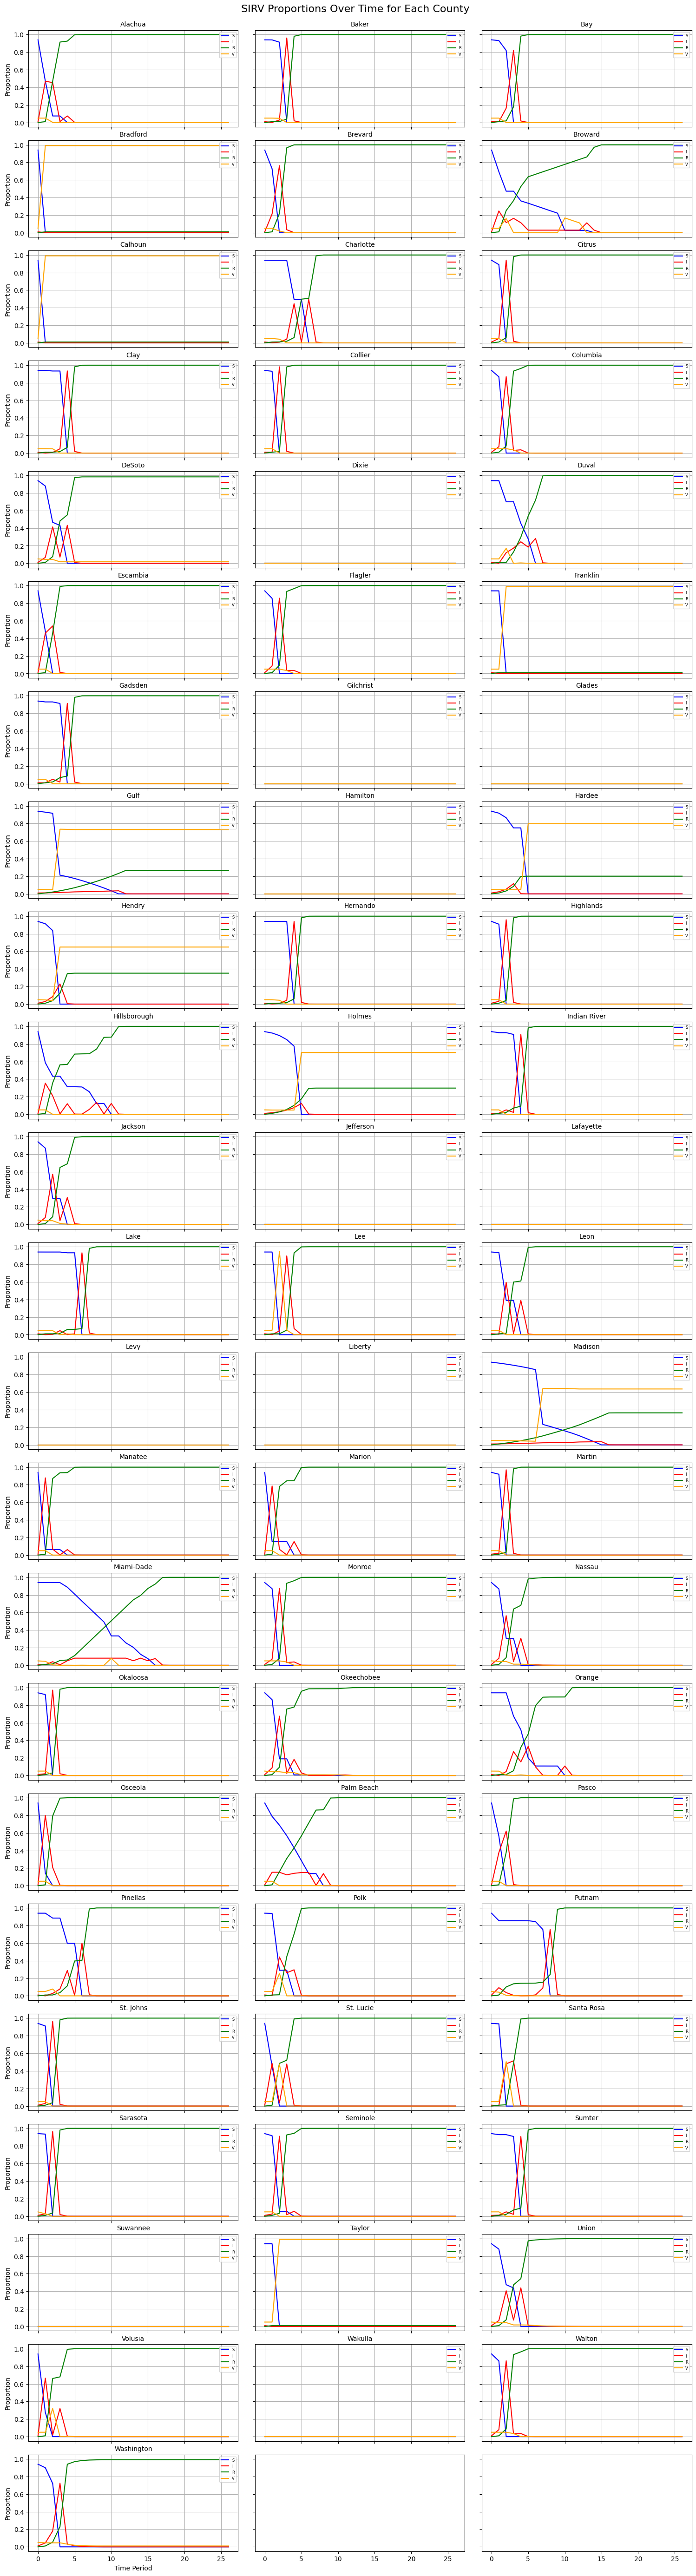

Travel data saved to 'outputData\travelData.csv'
Vaccine allocation data saved to 'outputData\vaccineAllocationData.csv'
Susceptible data saved to 'outputData\susceptibleData.csv'
Infected data saved to 'outputData\infectedData.csv'
Recovered data saved to 'outputData\recoveredData.csv'
Vaccinated data saved to 'outputData\vaccinatedData.csv'
Hospitalization data saved to 'outputData\hospitalizationData.csv'
Unmet demand data saved to 'outputData\unmetDemandData.csv'
Vaccinations administered data saved to 'outputData\vaccinationsAdministeredData.csv'


In [73]:
if model.status == GRB.OPTIMAL:
    saveAndPlotSIRVProportions(S, I_var, R, X, population, I, T, output_folder)
    saveDecisionVariables(Z, A, S, I_var, R, X, H, U, v, output_folder, T, T_prime, I, J)
else:
    print("No optimal solution found.")